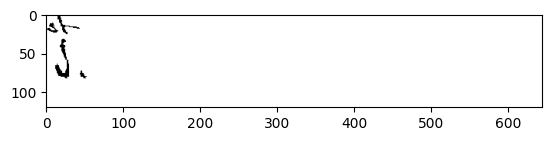

In [1]:
from matplotlib import pyplot as plt
import skimage as ski
import numpy as np
from skimage import io


PATH = '/content/drive/MyDrive/123OfAi/word_images_normalized'
PADDED_PATH = "/content/drive/MyDrive/123OfAi/padded_images"
GROUND_TRUTH_FILE = "/content/drive/MyDrive/123OfAi/word_labels.txt"



In [ ]:
image=io.imread (PADDED_PATH+"/270-19-08.png")
plt.imshow(image,cmap='gray')

In [2]:
image.shape
# print(image)
true_count = np.count_nonzero(image)
false_count = np.count_nonzero(~image)
print(true_count, false_count)

21743 3217


In [ ]:
def get_max_rows_cols():
  import os

  max_rows = 0
  max_cols = 0
  max_rows_image_path = ''
  max_cols_image_path = ''

  # Iterate through the images in the folder
  for filename in os.listdir(PATH):
      if filename.endswith(('.png')):  # Add more image extensions if needed
          image_path = PATH+ "/"+filename;
          # Read the image
          image = io.imread(image_path)
          # Get the dimensions of the current image
          rows, cols = image.shape  # Assuming color images

          # Update max dimensions if current image is larger
          if rows > max_rows :
              max_rows = rows
              max_rows_image_path = image_path

          if cols > max_cols:
              max_cols = cols
              max_cols_image_path = image_path

  # Print the information about the image with the largest dimensions
  print(f"Image with the largest dimensions:")
  print(f"R Path: {max_rows_image_path}")
  print(f"C Path: {max_cols_image_path}")
  print(f"Rows: {max_rows}")
  print(f"Columns: {max_cols}")
  return max_rows, max_cols

In [3]:
import warnings
import os

#  Pad the existing images with make it in sync with largest row and column value across the dataset
#  Save the images afetr padding at PADDED_PATH location
def pad_images():
  target_rows, target_cols = get_max_rows_cols()
  # target_rows, target_cols = 120, 645

  for filename in os.listdir(PATH):
      if filename.endswith(('.png')):
        image_path = PATH+ "/"+filename;
        # Read the image
        image = io.imread(image_path)
        pad_cols = max(0, target_cols - image.shape[1])
        padded_image = np.pad(image, ((0, 0), (0, pad_cols)), constant_values=True)
        with warnings.catch_warnings():
          warnings.simplefilter("ignore")
          io.imsave(PADDED_PATH+"/"+filename, padded_image.astype(bool))

pad_images()

In [2]:

import re

# Parse and cleanup the ground truth data to extract the word.
# Stores the cleaned data in gtruth_dictionary

gtruth_dict = {};

def extract_word(text):
    parts = text.split('_')
    return parts[0].replace('-', '')

def cleanup_word(text):
   return text.replace("s_cm",",").replace("s_pt",".")

def prepare_gtruth():
  with open(GROUND_TRUTH_FILE, 'r') as file:
    lines = file.readlines()
    for line in lines:
        file_name, word = line.strip().split(' ', 1)
        word = cleanup_word(word)
        match = re.search(r'\d+', word)
        result_value = ''.join(re.findall(r'\d', word)) if match else extract_word(word)
        gtruth_dict[file_name]= result_value;

prepare_gtruth()
# print(len(list(gtruth_dict.values())))


4894


In [3]:
import os

# create 1D arrayof each image and append to padded_img_arr
padded_img_arr = []
for filename in os.listdir(PADDED_PATH):
      if filename.endswith(('.png')):
        image_path = PADDED_PATH+ "/"+filename;
        image = io.imread(image_path)
        padded_img_arr.append(image.flatten())

In [43]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.neighbors import NearestNeighbors


X = padded_img_arr
y = list(gtruth_dict.values())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.array(X_train)
nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
nn_model.fit(X_train)


X_test = np.array(X_test)
distances, indices = nn_model.kneighbors(X_test, n_neighbors=3)


In [78]:
from tabulate import tabulate

data = []
for i,neighbors_indices in enumerate(indices[:10]):
  data.append({"word":y_test[i],"nearestIndex":list(neighbors_indices),"nearestWords":[y_train[i] for i in neighbors_indices.flatten()]})

# data[1]
table_data = [(entry['word'], entry['nearestIndex'], entry['nearestWords']) for entry in data]

print(table_data)


[('the', [2763, 2975, 72], ['Regiment.', 'to', 'can']), ('28', [551, 811, 3820], ['and', 'from', 'careful']), ('conveying', [2451, 1082, 1493], ['and', 'delivered', 'If']), ('We', [1438, 1220, 2622], ['I', 'we', 'get']), ('one', [3820, 292, 2529], ['careful', 'of', '30']), ('ordered', [2419, 2638, 1082], ['and', 'given', 'delivered']), ('no', [1717, 3861, 1542], ['so', 'Houses', 'as']), ('for', [247, 2169, 3861], ['Letters,', 'have', 'Houses']), ('This', [2714, 3019, 1540], ['delayss', 'to', 'Sergeant,']), ('arrived.', [1894, 2344, 507], ['is', 'any', 'of'])]
